In [1]:
import numpy as np
import torch
from speed_tests import PyTorch, NumPy
from torch.nn import MSELoss
import numpy.linalg as LA
from torch.autograd import Variable
import time

In [2]:
def torch_grad(A, x, y):
    mse = MSELoss()
    m = mse.forward(A @ x, y)
    m.backward()
    return x.grad
        
def numpy_grad(A, x, y):
    return (2*A.T@(A@x - y)) * 1 / len(y)

In [3]:
def time_fn(fn, *args, limit=1, **kwargs):
    times = []
    start_time = time.time()
    while True:
        start = time.time()
        r = fn(*args, **kwargs)
        end = time.time()
        times += [end - start]
        if time.time() - start_time > limit:
            break
    if type(r) != np.ndarray:
        r = r.data.numpy()
    return {'result': r,
            'time': min(times),
            'repeats': len(times)}

In [4]:
def time_fn_with_size(fn, n=None, d=10, seed=42, use_torch=False):
    np.random.seed(42)
    n = 10*d
    A = np.random.randn(n, d)
    x = np.random.randn(d)
    y = A@x + n * 0.1 * np.random.randn(n)
    if use_torch:
        A = Variable(torch.from_numpy(A), requires_grad=False)
        y = Variable(torch.from_numpy(y), requires_grad=False)
        x = Variable(torch.from_numpy(x), requires_grad=True)
    return {'library': 'torch' if use_torch else 'numpy',
            'seed': seed, 'n': n, 'd': d,
            **time_fn(fn, A, x, y)}

In [25]:
data = []

In [27]:
seed = 42
fn_use_torch = {numpy_grad: False, torch_grad: True}
for repeat in range(10):
    for fn, use_torch in fn_use_torch.items():
        for d in np.logspace(1, np.log10(5e3), num=10, dtype=int):
            print(repeat, d, fn)
            data += [time_fn_with_size(fn, d=d, seed=seed,
                              use_torch=use_torch)]

10 <function numpy_grad at 0x10c47b620>
19 <function numpy_grad at 0x10c47b620>
39 <function numpy_grad at 0x10c47b620>
79 <function numpy_grad at 0x10c47b620>
158 <function numpy_grad at 0x10c47b620>
315 <function numpy_grad at 0x10c47b620>
629 <function numpy_grad at 0x10c47b620>
1256 <function numpy_grad at 0x10c47b620>
2506 <function numpy_grad at 0x10c47b620>
4999 <function numpy_grad at 0x10c47b620>
10 <function torch_grad at 0x10c47b6a8>
19 <function torch_grad at 0x10c47b6a8>
39 <function torch_grad at 0x10c47b6a8>
79 <function torch_grad at 0x10c47b6a8>
158 <function torch_grad at 0x10c47b6a8>
315 <function torch_grad at 0x10c47b6a8>
629 <function torch_grad at 0x10c47b6a8>
1256 <function torch_grad at 0x10c47b6a8>
2506 <function torch_grad at 0x10c47b6a8>
4999 <function torch_grad at 0x10c47b6a8>
10 <function numpy_grad at 0x10c47b620>
19 <function numpy_grad at 0x10c47b620>
39 <function numpy_grad at 0x10c47b620>
79 <function numpy_grad at 0x10c47b620>
158 <function numpy_gr

In [46]:
import pandas as pd
from altair import Chart
df = pd.DataFrame(data)
# df.to_csv('grad-timings.csv')
df.head()

220

In [4]:
import pandas as pd
# df = pd.read_csv('grad-timings.csv')

In [5]:
show = df.pivot_table(index='d', columns='library', values='time',
                      aggfunc=np.min)
show

library,numpy,torch
d,,
10,0.000007,0.000158
19,0.000011,0.000163
39,0.000024,0.000188
79,0.000076,0.000208
158,0.000497,0.000361
315,0.003804,0.001304
629,0.014424,0.003788
1256,0.059462,0.013757
2506,0.322136,0.054805


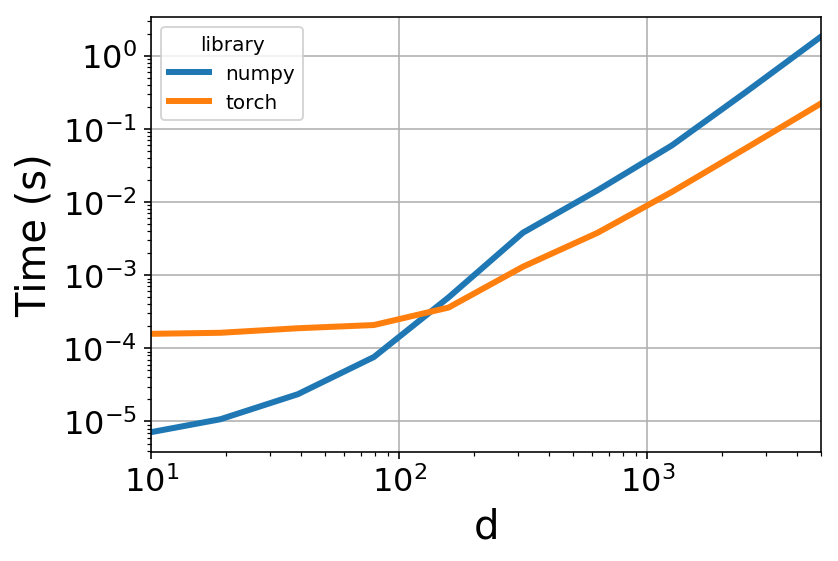

In [6]:
import matplotlib.pyplot as plt
plt.style.use('presentation')
show.plot(logx=True, logy=True)
plt.ylabel('Time (s)')
# plt.grid(which='minor')
plt.grid(which='major')

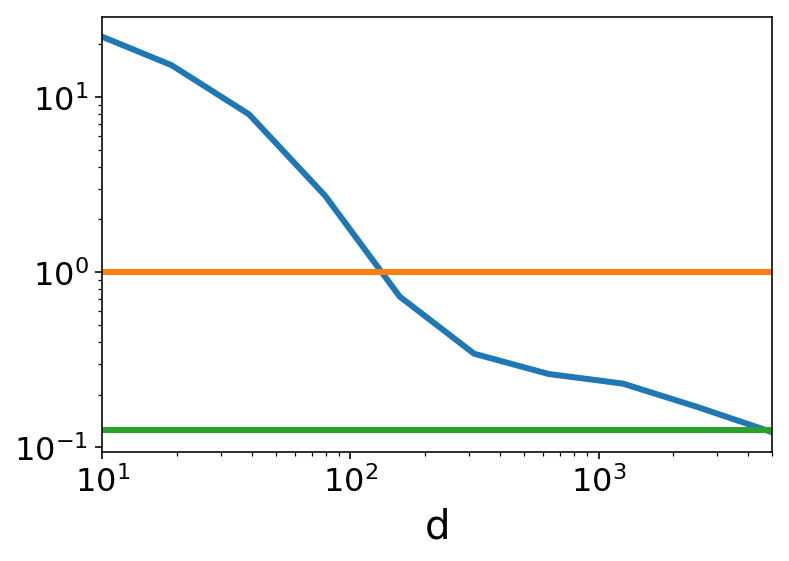

In [10]:
speedup = show['torch'] / show['numpy'] 
speedup.plot(logx=True, logy=True)
plt.plot([show.index.min(), show.index.max()], [1, 1])
# because I have 8 cores on this system
plt.plot([show.index.min(), show.index.max()], [1/8, 1/8])